<a href="https://colab.research.google.com/github/ovr4/NIST/blob/main/HTML_Table_Extract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **This program extracts tabular data from cement/concrete research articles**
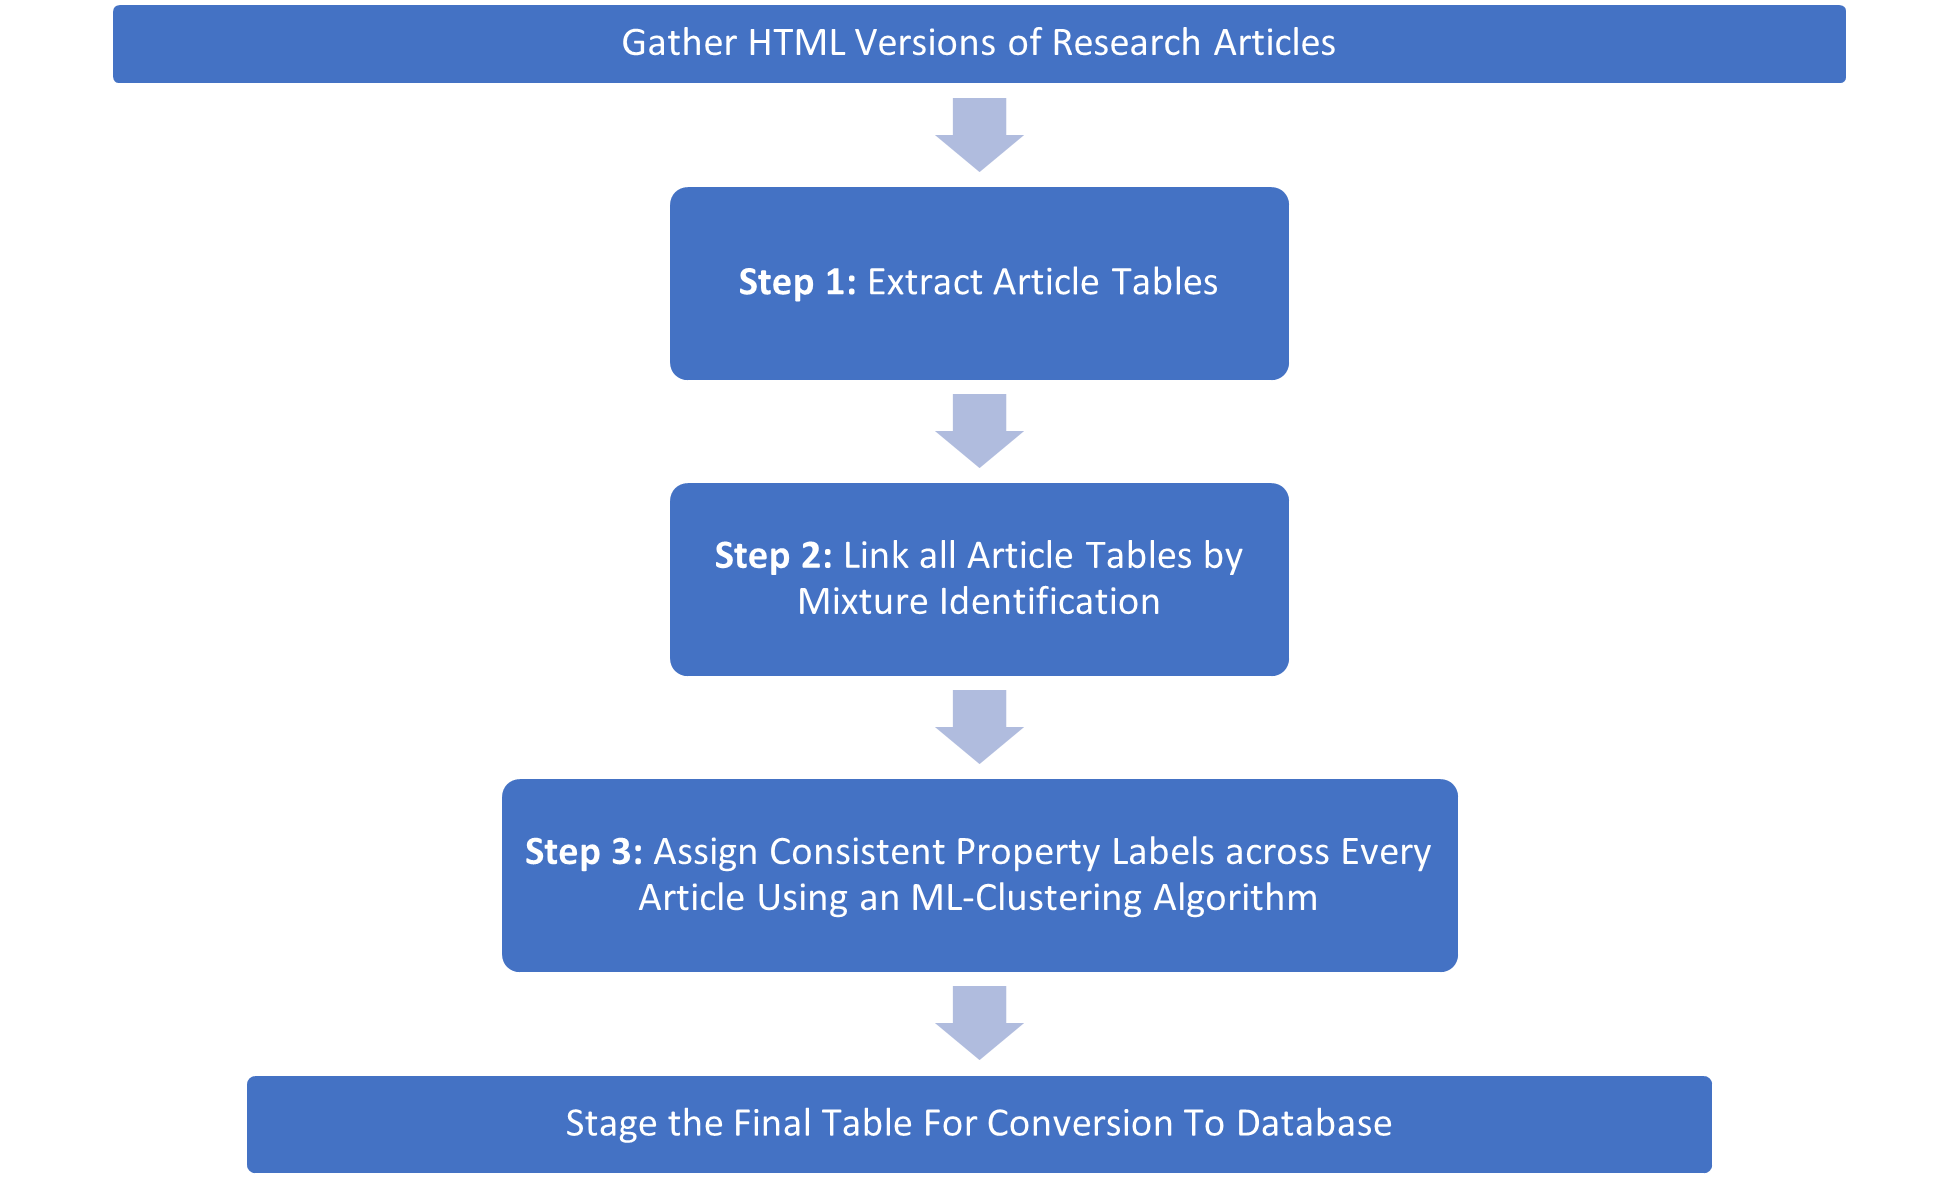

**Installing additional Python Libraries**

In [63]:
#pip install bleach
#pip install beautifulsoup4
#pip install units
#pip install pint

In [64]:
pip install pint

In [65]:
pip install units

**Importing additional python libraries/modules**

In [66]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import bleach
import re
import numpy as np

**Mounting google drive to access html files of articles.**

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Default CONSTANTS, specified by users, that identify the units, compoounds, raw materials, product identifications to look for when extracting data from the article tables.**

•**IDS_TO_LOOK_FOR**: This is a list of potential table headers that describe mixture codes. The contents of this list would indicate whether the column of a Table is referring to mixture codes that link various table entries within the article together. 

*   Example: ['Authors', 'system', 'code', 'ID', 'No.', 'Mix', 'Mixtures', 'Code', 'name', 'mix', 'Mixture', 'Curing', 'Notation' , 'N ']
*   Note: Need knowledge of how mixtures of concrete/mortar/paste are labelled in various articles. 



•	**LIST_OF_ALL_UNITS**: This is a list of units used in the cement/concrete literature. Knowledge of the industry is necessary in this case to identify whether a sequence of strings contains a relevant unit.


*   Example: ['%', 'ratio', 'kg/m2', 'kg/m3', 'by cement weight', 'weight', 'mm', 'Pa', 'Pa.s', 'g', 'MPa', 'N', 'N.mm', 'wt. %', 'h−1', 'kg/m', 'kg', 'k', 'min', 'hours', 'time', 'set time', '°C', 'ηθ', 'sec', 'N.mm', 'm2', 'η']
*   Note: Need a much larger unit list to search through to identify units in tables. Search through the literature and identify all the units that have been used and add them to this unit list.


•	**COMPOUNDS_TO_LOOK_FOR**: This is a list of compounds that make up the raw materials (cement, fly ash, etc) used to prepare the final products (concrete, mortar). This list should include all potential compounds to look out for in Tables (especially the compositional tables) of articles. 


*   Example: ['CaO', 'SiO2', 'Al2O3', 'Fe2O3', 'MgO', 'K2O', 'Na2O', 'SO3', 'SrO', 'P2O5', 'TiO2', 'MoO3',  'BaO', 'Cl', 'MnO', 'C3S', 'C2S', 'C3A', 'C4AF', 'ZrO2', 'Cr2O3', 'CuO', 'ZnO', 'Mn2O3', 'LOI', 'Loss on ignition', 'Specific gravity', 'Specific surface', 'Setting time', 'Compressive ', 'Flexural', 'Flexural ', 'Density', 'surface area', 'SSD', 'OD', 'Specific', 'Bulk', 'Blaine', 'gravity', 'sieve']



•	**PROP_DICT**: This dictionary (dict) identifies the raw materials that make up the concrete/mortar/paste products. They, along with the COMPOUNDS_TO_LOOK_FOR, form the basis of the compositional table for that article – see P2 function Z for details. The keys in the dictionary refers to the raw material, while the values of each key indicates the synonyms/alternatives names for the raw material. If more raw materials are identified in articles, add their key to the PROP_DICT and include alternative names for this raw material as the key’s values. 


*   	Example: {'Cement': ['Cement', 'OPC', 'ASTM', 'P.O', 'P·O', 'cement'], 'Limestone': ['Limestone', 'Limestone filler', 'LF'], 'Fly ash': ['FA', 'FAM', 'Fly Ash', 'Fly ash'], 'Slag': ['Slag', 'SL'], 'Water': ['Water', 'H2O'], 'Quartz powder': ['Quartz powder'], 'Sand': ['Quartz sand', 'Sand', 'Fine aggregates', 'sand'], 'Coarse': ['Coarse aggregates', 'Coarse '], 'Metakaolin': ['MK'], 'Silica': ['Silica', 'Silica fume']}


•	**FINAL_PRODUCTS**: This a dict of the final products to extract from the articles – represented by the key (product names), and values (the alternative names of the products to identify in various tables).

*  Example: {'CONCRETE': ['SCC', 'Concrete', 'concrete', 'SCLC', 'HPC', 'UHPC'], 'PASTE': ['paste', 'Paste'], 'MORTAR': ['Mortar', 'mortar', 'grout', 'Grout']}









In [68]:
'''CONSTANTS SPECIFIED BY USERS'''

## Raw materials 
PROP_DICT = {'Cement': ['Cement', 'OPC', 'ASTM', 'P.O', 'P·O', 'cement'], 'Limestone': ['Limestone', 'Limestone filler', 'LF'], 
                  'Fly ash': ['FA', 'FAM', 'Fly Ash', 'Fly ash'], 'Slag': ['Slag', 'SL'],
                  'Water': ['Water', 'H2O'], 'Quartz powder': ['Quartz powder'],
                  'Sand': ['Quartz sand', 'Sand', 'Fine aggregates', 'sand'],
                  'Coarse': ['Coarse aggregates', 'Coarse '], 'Metakaolin': ['MK'],
                  'Silica': ['Silica', 'Silica fume']}

### Final products  
FINAL_PRODUCTS = {'CONCRETE': ['SCC', 'Concrete', 'concrete', 'SCLC', 'HPC', 'UHPC'], 'PASTE': ['paste', 'Paste'], 'MORTAR': ['Mortar', 'mortar', 'grout', 'Grout']}


###Compositions of materials 
COMPOUNDS_TO_LOOK_FOR = ['CaO', 'SiO2', 'Al2O3', 'Fe2O3', 
                            'MgO', 'K2O', 'Na2O', 'SO3', 'SrO', 'P2O5', 
                            'TiO2', 'MoO3',  'BaO', 'Cl', 'MnO', 'C3S', 
                            'C2S', 'C3A', 'C4AF', 'ZrO2', 'Cr2O3', 'CuO', 
                            'ZnO', 'Mn2O3', 'LOI', 'Loss on ignition']



###List of all probable units for this subfield
LIST_OF_ALL_UNITS = ['%', 'ratio', 'kg/m2', 'kg/m3', 'by cement weight', 'weight',
                          'mm', 'Pa', 'Pa.s', 'g', 'MPa', 'N', 'N.mm' 
                          'wt. %', 'h−1', 'kg/m', 'kg', 
                          'k', 'min', 'hours', 'time', 'set time', '°C', 'ηθ', 'sec', 'N.mm', 'm2', 'η', 'nm', 
                          'kN', 'm2/kg', 'μm', 'ml/s', 'N']


##Header ID to look for i.e. the likely header name of unique mixtures in article
IDS_TO_LOOK_FOR = ['Authors', 'system', 'code', 'ID', 'No.', 'Mix', 'Material', 'Mixtures', 'Code', 'name', 'mix', 'Mixture', 'Notation' , 'N ', 'batch', 'Label', 'label']
control_ids = ['Control', 'CO']


###Place holders for entries to refer back to 
place_holder = 'NA'

##Making all fixed variables global across all functions
global IDS_TO_LOOK_FOR, control_ids
global COMPOUNDS_TO_LOOK_FOR
global PROP_DICT, FINAL_PRODUCTS
global LIST_OF_ALL_UNITS, keep

**Step 1 (Extract Article Tables
):** The first step involves of this process entails reading html files and parsing out tabular data from these files. In this step, the Beautifulsoup library was heavily used to read and extract data based on the pertinent html tags associated with table columns and rows in the file. Beautifulsoup uses various html parses but the htmlib4 was chosen. 

In [69]:
 def get_doi(path): ## returns paper doi - ONLY WORKS FOR SCIENCE-DIRECT FILES
  '''this function extracts the doi of the article from its html file'''

  '''    **Parameters**

        path: *str*
            A string containing the path of the article to be extracted.

        **Returns**
          DOI of the article
  '''            
  soup = BeautifulSoup(path, 'html5lib')
  s = soup.find_all('html')
  h = s[0].find_all('head')
  for mname in h[0].find_all('meta'):
      mname = str(mname)
      if 'name="citation_doi"' in mname:
        doi = mname.split('content=')[1].split('name=')[0]
        doi = doi.replace('"', '')
        return doi    
 
 class HTMLTableParser:
       
        def parse_url(self, url):
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'xml') #'html5lib', 'html.parser', lxml, lxml-xml, xml 
            return [(table['id'],self.parse_html_table(table))\
                    for table in soup.find_all('table')]

        def parse_html_file(self, path, table_id = 'All'):
            ''' This method extracts the tables from articles (i.e. path) and returns each table as a pandas dataFrame, along with its title and table headers'''

            '''    **Parameters**

                  path: *str*
                      A string containing the path of the article to be extracted.
                  table_id: *int* or 'All'
                      The specific ID of table to be extracted or extract 'All' the tables
                
                **Returns**
                A list of table properties (table title, pandas Dataframe, table headers)
            '''
            soup = BeautifulSoup(path, 'html5lib') ## lxml or html.parser or xml or html5lib


            all_tables = soup.find_all('table')
            all_divs = soup.find_all('div')
            table_title_index_list, table_title_list = [], []
            
            for i in all_divs:
              table_title = self.parse_html_table_title(i)
              if table_title != None:
                table_index = int(table_title.split('.')[0].split('Table')[1])

                if table_index not in table_title_index_list:
                  table_title_index_list.append(table_index)
                  table_title_list.append(table_title)
              else:
                continue
            
            c_m_p = concrete_mortar_paste(table_title_list)

            if table_id == 'All':
              all_list = []
              new_c_m_p = []
              for table, title, c_mp in zip(all_tables, table_title_list, c_m_p):
                try:
                  all_list.append(self.parse_html_table(table, title, c_mp))                 
                except:
                  pass
              return all_list
            else:  
              return self.parse_html_table(all_tables[table_id-1], table_title_list[table_id-1], c_m_p[table_id-1])


        def parse_html_table_title(self, div): ## returns table name and title
          
          '''this method extracts the title of a table'''
          
          if div.find_all('table') != []:

            if div.find_all('span') != []:

              for spans in div.find_all('span'):

                spans = str(spans)
                if 'span class="label"' in spans:
                  spans_list = spans.split('span class="label"')[1].split('</span>') ## this identifies the Table id
                  table_id = spans_list[0]
                                  
                  
                  if 'Table' in table_id:
                    table_title = spans_list[1]
                    table_title = BeautifulSoup(table_title)
                    table_title = table_title.get_text()

                    table_title = table_id+table_title
                    table_title = table_title.replace('>', '')
                    
                    return table_title
                   
          return None

        def parse_html_table(self, table, title, c_m_p):
            
            '''this method returns the table as pandas DataFrame and table headers'''
            n_columns = 0
            n_rows=0
            column_names = []
            sub_column_names= []
            sub_sub_column_names = []
            header_row_count = 0
            first_non_header_row = [] 
            move_to_second_column = False

            # Find number of rows and columns, we also find the column titles if we can

            for row in table.find_all('tr'):
                
                # Determine the number of rows in the table
                td_tags = row.find_all('td')

                holder = 0 

                if len(td_tags) >= holder: ### switched from 0 to 1 - assumes that every table has at least two columns
                    n_rows+=1
                    if n_columns == 0:
                        # Set the number of columns for our table
                        n_columns = len(td_tags)
                        for the_column in td_tags: ## getting the first non header row
                          first_non_header_row.append(the_column.get_text())                          
                          move_to_second_column = True


                        
                # Handle column names if we find them
                th_tags = row.find_all('th') 
                if len(th_tags) > 0 and len(column_names) == 0 and header_row_count == 0:
                    for th in th_tags:
                        column_names.append(th.get_text())                                              
                    header_row_count += 1
                
                # Handle sub_column_names if we find them
                elif len(th_tags) > 0 and len(sub_column_names) == 0 and header_row_count == 1:
                    for th in th_tags:
                      sub_column_names.append(th.get_text())
                    header_row_count += 1                
                
                #Handles the second sub header if we find them
                elif len(th_tags) > 0 and len(sub_sub_column_names) == 0 and header_row_count == 2: ## Cases where there are two sub headers
                    for th in th_tags:
                      sub_sub_column_names.append(th.get_text())                
                

            header_row_count = 0
            colspan_column_names = []
            colspan_sub_column_names = []
            colspan_sub_sub_column_names = []

            for row in table.find_all('tr'):
                th_tags = row.find_all('th')
                if header_row_count == 0: 
                  for th in th_tags:
                    if 'colspan' in th.attrs and th.attrs['colspan'].isdigit():
                      col = int(th.attrs['colspan'])
                      colspan_column_names.append(col)
                    else:
                      colspan_column_names.append(1)
                  header_row_count += 1

                elif header_row_count == 1: 
                  for th in th_tags:
                    if 'colspan' in th.attrs and th.attrs['colspan'].isdigit():

                      col = int(th.attrs['colspan'])
                      colspan_column_names.append(col)
                    else:
                      colspan_sub_column_names.append(1)                    
                  header_row_count += 1

                elif header_row_count == 2: 
                  for th in th_tags:

                    if 'colspan' in th.attrs and th.attrs['colspan'].isdigit():
                      col = int(th.attrs['colspan'])
                      colspan_column_names.append(col)
                    else:
                      colspan_sub_sub_column_names.append(1)
                  header_row_count += 1                  
                    

            def get_rid_of_empty_space(col_name, colspan):
              new_col_name = []
              new_colspan = []
              
              for i, j in zip(col_name, colspan):
                if i != '':
                  new_col_name.append(i)
                  new_colspan.append(j)
              return new_col_name, new_colspan

            def update_empty_space_in_first_row(col_name, colspan):
              new_col_name = []
              new_colspan = []
              use_old_approach = False
              empyt_first_column = False
              index_track = -1
              for i, j in zip(col_name, colspan):
                index_track+=1
                
                if i != '':
                  new_col_name.append(i)
                  new_colspan.append(j)
                
                else:  
                  if index_track == 0:
                    new_col_name.append('Mix / COMP')
                    new_colspan.append(1)
                    empyt_first_column = True
                    use_old_approach = True
                  
                  else:
                    if new_colspan[index_track-1] == 0:
                      new_colspan[index_track-1] += 1
                    else:
                      new_col_name.append('BLANK HEADER')
                      new_colspan.append(j)
                                 
              return new_col_name, new_colspan, use_old_approach
            
            column_names, colspan_column_names, use_old_approach = update_empty_space_in_first_row(column_names, colspan_column_names)            
            
            sub_column_names, colspan_sub_column_names = get_rid_of_empty_space(sub_column_names, colspan_sub_column_names)
            
            sub_sub_column_names, colspan_sub_sub_column_names = get_rid_of_empty_space(sub_sub_column_names, colspan_sub_sub_column_names)

            ## Using method 1 to determine column names
            if not use_old_approach and max(len(colspan_column_names), len(colspan_sub_column_names), len(colspan_sub_sub_column_names)) != 0: 
              columns = []
              cols_col_index_rec = 0
              sub_cols_index_rec = 0
              sub_sub_cols_index_rec = 0
              full_header_list = []
              for col, span in zip(column_names, colspan_column_names):

                if span == 1:
                  columns.append(col)
                  full_header_list.append([col])

                else:
                  holder_list= [[col]]
                  holder_list.append(sub_column_names[sub_cols_index_rec:span+sub_cols_index_rec])
                                   
                  for sub_index, sub_span in enumerate(colspan_sub_column_names[sub_cols_index_rec:span+sub_cols_index_rec]):

                    if sub_span == 1:
                      columns.append(sub_column_names[sub_cols_index_rec+sub_index])

                    else:
                      holder_list.append(sub_column_names[sub_sub_cols_index_rec:sub_span+sub_sub_cols_index_rec])
                      for sub_sub_index, sub_sub_span in enumerate(colspan_sub_sub_column_names[sub_sub_cols_index_rec:sub_span+sub_sub_cols_index_rec]):               
                        columns.append(sub_sub_column_names[sub_sub_cols_index_rec+sub_sub_index])

                  full_header_list.append(holder_list)
                  sub_cols_index_rec += span
                  sub_sub_cols_index_rec +=  sub_span
            
            ## Using method 2 (an older approach) to determine column names
            else:
              columns = old_approach(column_names, sub_column_names, sub_sub_column_names, n_columns)
              cols_col_index_rec = 0
              sub_cols_index_rec = 0
              sub_sub_cols_index_rec = 0
              full_header_list = []
              for col, span in zip(column_names, colspan_column_names):
                if span == 1:
                  full_header_list.append([col])
                else:
                  holder_list= [[col]]
                  holder_list.append(sub_column_names[sub_cols_index_rec:span+sub_cols_index_rec])
                                   
                  for sub_index, sub_span in enumerate(colspan_sub_column_names[sub_cols_index_rec:span+sub_cols_index_rec]):

                    if sub_span == 1:
                      pass
                  
                    else:
                      holder_list.append(sub_column_names[sub_sub_cols_index_rec:sub_span+sub_sub_cols_index_rec])
                    sub_sub_cols_index_rec +=  sub_span
                  full_header_list.append(holder_list)
                  sub_cols_index_rec += span
                  

            def priority_headers(columns):
              #switch_2 = 1
              change_No = False
              mix_headers =  [header for header in columns if any(head in header for head in IDS_TO_LOOK_FOR) and not any('('+unit_+')' in header for unit_ in LIST_OF_ALL_UNITS)] ##gets all Ids
              
              new_columns = []
              ##print('O')
              for index, col in enumerate(columns):
                if col in mix_headers:
                  if mix_headers.count(col) > 1:
                    new_columns.append('!'*index+str(col))
                  else:
                    new_columns.append(col)
                else:
                  new_columns.append(col)
              for index, col in enumerate(columns):
                if 'No.' in columns and 'No.' not in col and any(header in col for header in IDS_TO_LOOK_FOR):
                  switch_2 = index
                  change_No = True


          
              if 'No.' in columns and change_No: ##No and material/mix etc
                switch_1 = columns.index('No.')
                columns[switch_1] = 'No!'
                return columns, switch_1, switch_2

              else:
                return columns, 1, 1

            columns, switch_1, switch_2 = priority_headers(columns)
            
            


            columns = remove_math_symbols(columns)
            final_column_names = columns
            df = pd.DataFrame(columns = columns,
                              index= range(0,n_rows))
            
 

            '''Here we build the tables'''
 
            final_row_list = []
            final_final_row_list = []
            max_copy_rows = -1
            
            for row_marker, row in enumerate(table.find_all('tr')):
                empty = True
                column_marker = 0

                if row_marker == 0:
                  pass
                
                columns = row.find_all('td')
                if len(columns) == len(final_column_names)-1:
                  columns=row.find_all(['th', 'td'])


                holder_row_list = []
               
                
                if row_marker > max_copy_rows:
                  final_final_row_list = []
                  for column in columns:
                      final_row_list = []
                      if 'rowspan' in column.attrs and column.attrs['rowspan'].isdigit():
                        number_row = int(column.attrs['rowspan'])                                              
                        holder_row_list = [row_marker+ i for i in range(1, number_row)]

                        for i in holder_row_list:
                          final_row_list.append(i)
                        
                        final_final_row_list.append(final_row_list)
                        max_copy_rows = max(final_row_list)

                    
                      else:
                        final_final_row_list.append([])
                        pass


                confirm = True
                for index, i in enumerate(final_final_row_list):
                  if i == []:
                    col_index_to_add = index 
                    confirm = False
                    break
                                
                try:
                  new_add_rows_name +=1
                except:
                  pass
                
                for col_index, column in enumerate(columns):

                    if row_marker in final_final_row_list[col_index]:                      
                      add_rows_name +=1                      
                      df.iat[row_marker,column_marker] = copy_forward_list[col_index]+'-'+str(new_add_rows_name) #copy_forward+'-'+str(add_rows_name)                                             
                      df.iat[row_marker,col_index+col_index_to_add] = column.get_text()

                    elif final_final_row_list[col_index] == [] and len(columns) < n_columns:
                       df.iat[row_marker,column_marker+col_index_to_add] = column.get_text()
                    else:
                      df.iat[row_marker,column_marker] = column.get_text()                      
                      
                      if column_marker == 0:
                        copy_forward = column.get_text()
                        add_rows_name = 0
                        new_add_rows_name = 0
                        copy_forward_list = []                        
                      copy_forward_list.append(column.get_text())

                    column_marker += 1

            # Convert to float if possible
            for col in df:
                try:
                    df[col] = df[col].astype(float)
                except ValueError:
                    pass

            df.dropna(0, 'all', inplace=True)

            if switch_1 == 0:
              df = df_column_switch(df, df.columns[switch_1], df.columns[switch_2])
              final_column_names = list(df.columns)

            
            column_is_header = column_checkers(df)
            is_first_column_a_header = column_is_header[0]
            
            
            ### this section fills the column and sub_column_names and determines units

            if  'BLANK HEADER' not in df.columns:
              pass 

            else:
              if is_first_column_a_header and len(sub_column_names) > len(sub_sub_column_names):
                if sub_column_names[0] == 'BLANK HEADER':
                  final_column_names = [column_names[0]]+sub_column_names[1:]                  
                else:  
                  final_column_names = [column_names[0]]+sub_column_names
                df.columns = final_column_names
              elif is_first_column_a_header and len(sub_column_names) < len(sub_sub_column_names):
                final_column_names = [column_names[0]]+sub_sub_column_names
                df.columns = final_column_names
            
            if len(sub_column_names) >= len(sub_sub_column_names):
              likely_unit_col = column_names
              likely_colspan = colspan_column_names
            elif len(sub_column_names) < len(sub_sub_column_names):
              likely_unit_col = sub_column_names
              likely_colspan = colspan_sub_column_names


            ## UNIT CLEANING

            number_of_same_entries = sum(x == y for x, y in zip(final_column_names, likely_unit_col))
            if number_of_same_entries != 0 and number_of_same_entries != len(final_column_names):
              if check_units(likely_unit_col).count('No unit') == len(likely_unit_col): ##checking if units are in title
                the_unit = check_units(title)
                for index, col in enumerate(final_column_names):
                  if not column_is_header[index] and not check_units(col, True):
                    final_column_names[index] = col +'('+the_unit+')'
                    df.columns = final_column_names
              else:
                the_unit = check_units(likely_unit_col)
                for index_p, i in enumerate(range(number_of_same_entries, len(likely_unit_col))):
                  from_ = likely_colspan[i-1]*index_p+number_of_same_entries
                  try:
                    if the_unit[i+1] == 'No unit':
                      to_ = from_+ likely_colspan[i]+1
                    else:
                      to_ = from_+ likely_colspan[i]

                  except:
                      to_ = from_+ likely_colspan[i]
                  
                  for index, col in zip(range(from_,to_), final_column_names[from_:to_]):
                    if not check_units(col, True):
                      final_column_names[index] = likely_unit_col[i]+'/'+ col +'('+the_unit[i]+')'
                    else:
                      final_column_names[index] = likely_unit_col[i]+'/'+ col
                df.columns = final_column_names             
            
            else:
              if check_units(likely_unit_col).count('No unit') == len(likely_unit_col): ##checking if units are in title
                the_unit = check_units(title)
                for index, col in enumerate(final_column_names):
                  if not column_is_header[index] and not check_units(col, True):
                    final_column_names[index] = col +'('+the_unit+')'
                    df.columns = final_column_names
              else:
                pass
            
            ### FINAL STEPS OF CLEANING (AUXILLIARY)

            df = swap_first_and_second_column(df)


            df = convert_ids_to_string(df)



            if should_table_be_transposed(df): ## TRANSPOSE COMPOSTIONAL TABLES              
              new_df, new_full_header_list = transpose_table(df)
              new_df = make_first_colname_material(new_df)
              new_df.columns = clean_table_headers(new_df.columns)
              return [title, new_df, column_is_header, new_full_header_list, c_m_p]

            df.columns = clean_table_headers(df.columns)
            pot_new_df, t_f, new_col_added = special_table(df) 


            if t_f:
              df = pot_new_df.copy(deep = True)
            if new_col_added:
              column_is_header.append(True)
              full_header_list.append([df.columns[-1]])
            df = make_first_colname_material(df)


            if omit_table(df):
              raise Exception('This table has too many empty cells so it wasnt extracted')

            
            df = sandwhich_table(df, full_header_list, df.columns)
            
            return [title, df, column_is_header, full_header_list, c_m_p]


**Step 2 (Link all article Tables by mixture codes):** This process links each table in an article by their mixture identification (e.g. Mix no.) and chemical compositions of raw materials (e.g. OPC and FAM). This results in a aggregated table for each article containing its studied mixtures, their associated material and compositional properties, article DOI, and the article title.

In [70]:
class ExtractDF:

    '''takes in a list of LISTS - table properties i.e. title, df, column_rows_are_headers, list of headers and sub_headers, and whether to transpose the table or not
     for each paper and links the tables together'''

    def __init__(self, t_prop, article_title, article_doi):
      self.t_prop = t_prop[0]#[0] #'''all tables are linked together'''
      self.article_title = article_title
      self.doi = article_doi      


    def check_improper_table_heading(self):
      '''this method updates the tabular headers for tables in a particular articles'''

      
      df_of_tables = [table[1] for table in self.t_prop]
      df_headers = [[header for header in df.columns if any(head in header for head in IDS_TO_LOOK_FOR) and not any('('+unit_+')' in header for unit_ in LIST_OF_ALL_UNITS)] for df in df_of_tables]
      df_title = [table[0] for table in self.t_prop]

      def update_id_with_title(title):
        broken = title.split()
        for index, breaks in enumerate(broken):
          if any(breaks == unit for unit in LIST_OF_ALL_UNITS):
            return ' '.join(broken[index-1:])
          elif '%' in breaks:
            return ' '.join(broken[index:])

        try:
          return ' '.join(broken[:5]) ##first 5 entries
        except:
          return ' '.join(broken[:])
              

      update_headers = []
      checker_list = []
      for df1, headers1 in zip(df_of_tables, df_headers):
        df1_cols = df1.columns
        for df2, headers2 in zip(df_of_tables, df_headers):
          df2_cols = df2.columns
          if not df1.equals(df2):
            for head1 in headers1:
              df1_entry = list(df1[head1])
              for head2 in headers2:
                df2_entry = list(df2[head2])
                similar_entry = len(set(df1_entry) & set(df2_entry))
                if similar_entry > 0 and head2 != head1:
                  new_entry = '/'.join(sorted([head1, head2]))
                  old_entry = head1
                  if list(df1.columns) not in checker_list: 
                    update_headers.append([df1, {old_entry: new_entry}])
                    checker_list.append(list(df1.columns))
      new_df = []
      for df in df_of_tables:
        got_it = False
        for df_to_up in update_headers:
          if df_to_up[0].equals(df):
           df.rename(columns = df_to_up[1], inplace = True)
           new_df.append(df)
           got_it = True
        if not got_it:
          new_df.append(df)
        
      
      new_df_mix_headers = [[header for header in df.columns if any(head in header for head in IDS_TO_LOOK_FOR) and not any('('+unit_+')' in header for unit_ in LIST_OF_ALL_UNITS)] for df in new_df]
      '''this method looks for tables that repeat the same columns and first column IDs - see '''
      #CASE A same headers and first columns across each table
      dict_ = {}
      joined_col = []
      for n_df, title in zip(new_df, df_title):
        columns = ''.join(list(n_df.columns))
        mix_ids = ''.join(map(str, list(n_df.iloc[:, 0]))) ##first col only 
        table_id = int(title.split('.')[0].split('Table')[-1])
        joined_col.append([columns, mix_ids, table_id])
      
      tables_to_check = []
      for col1 in joined_col:
        for col2 in joined_col:
          if col1[2] != col2[2] and len(common(col1[0], col2[0])) >= 0.9*max(len(col1[0]), len(col2[0])):
            if len(common(col1[1], col2[1])) >= 0.9*max(len(col1[1]), len(col2[1])):
              tables_to_check.append(col1[2])
              tables_to_check.append(col2[2])

      tables_to_check = list(set(tables_to_check))


      for n_df, headers, title in zip(new_df, new_df_mix_headers, df_title):
        if any('Table '+str(id) in title for id in tables_to_check):
          new_mixture_ids = []

          for mix in list(n_df.iloc[:, 0]):
            try:
              new_mix = str(mix) + '-' + update_id_with_title(''.join(title.split('.')[1]))
            except:
              new_mix = mix
            new_mixture_ids.append(new_mix)          
          n_df.iloc[:, 0] = new_mixture_ids

      #CASE B Same mixture ID-s within the table 
      for n_df, headers, title in zip(new_df, new_df_mix_headers, df_title):
        columns = n_df.columns
        repeat = [] 
        for index1, header in enumerate(headers):
          index_of_header = get_index_positions(list(columns), header)
          if len(index_of_header) == 1:
            index_of_header = index_of_header[0]
            mixture_entries = list(n_df[header])
          else:  
            repeat.append(header)
            break

          holder_new = []
          holder_rep = []
          for mixture in mixture_entries:
            if mixture not in holder_new:
              holder_new.append(mixture)
            else:
              holder_rep.append(mixture)
          new_mixture_ids = []
          for index, mix in enumerate(mixture_entries):

            if mix in control_ids:
              new_mix = mix + '-' + update_id_with_title(''.join(title.split('.')[1]))
              new_mixture_ids.append(new_mix) 
             
            elif mix in holder_rep and not isNaN(mix):
              try:
                new_mix = mix+'-'+columns[index_of_header+1]+'='+str(n_df.iloc[index, index_of_header+1])
              except:
                new_mix = mix+'-'+columns[index_of_header+-1]+'='+str(n_df.iloc[index, index_of_header-1])

              new_mixture_ids.append(new_mix)
            else:
               new_mixture_ids.append(mix)

          n_df.iloc[:, index_of_header] = new_mixture_ids


      for i, n_df in zip(list(range(len(self.t_prop))), new_df):
        self.t_prop[i][1] = n_df
      
      return self.t_prop
        

    def extract_compositions(self):
      '''this method extracts the composition of cement, fly ash and slag in the article'''

      keep = []
      n_compounds_to_look_for = COMPOUNDS_TO_LOOK_FOR + keep  #+ LIST_OF_ALL_UNITS                            
      combinations = [' ', '', '(', ' (']
      new_comp = []
      for comp in n_compounds_to_look_for:
        n_l = [comb1+comp+comb2 for comb1 in combinations for comb2 in combinations]
        new_comp = new_comp + n_l

      n_compounds_to_look_for = n_compounds_to_look_for + new_comp
      full_header_list = []
      full_property_list = []
      for table_id, table in enumerate(self.t_prop):
        df = table[1]
        table_columns = df.columns
        first_col = table_columns[0]

        for index, row in df.iterrows():
          holder_list = []
          header_list = []
          for material in PROP_DICT.keys():
            if any(prop in str(row[first_col]) for prop in PROP_DICT[material]): ##if material is in table 
             for cols in table_columns:
               if any(comps in str(cols) for comps in n_compounds_to_look_for): ##composition is in row
                full_property_list.append(row[cols])
                if '(' in row[first_col] and '%' not in row[first_col]:
                  full_header_list.append(cols +' in/for '+row[first_col].split('(')[0] + ' ('+material+')' )
                else:
                  full_header_list.append(cols +' in/for '+row[first_col] + ' ('+material+')' )
      final_header = []

      holder = []
      holder_prop = []
      for i, j in zip(full_header_list, full_property_list):
        if j != '–' and j != np.nan:
          material, compound = get_compound_and_material(i)
          holder.append(compound +' in/for '+material)
          holder_prop.append(j) 
      full_header_list = holder
      full_property_list = holder_prop

      for i in full_header_list:
        to_add = set(i)
        for j in to_add:
          if j not in final_header:
            final_header.append(j)

      final_header = full_header_list
      new_df = pd.DataFrame(columns = final_header)
      final_row = [np.nan]*len(final_header)
      for prop, prop_header in zip(full_property_list, full_header_list):
          index_of_val = final_header.index(prop_header)
          final_row[index_of_val] = prop
      row_series = pd.Series(final_row, index = new_df.columns)

      number_nan = row_series.isna().sum(axis = 0)
      number_nan = final_row.count(np.nan)
      new_df = new_df.append(row_series, ignore_index=True)
      new_df = new_df.dropna(thresh=3)
      new_df.reset_index(drop=True, inplace=True)

      return new_df

    def make_table(self):
      ''''extracting propery data based on mixture identification'''

      all_id_w_table = []
      
      
      table_id_list = []
      table_title_list= []
      splitters = [' ', '/', '.']

      for table_id, table in enumerate(self.t_prop):
        table_id_list.append(int(table[0].split('.')[0].split('Table')[1]))
        ids = []
        table_title_list.append(table[0])
        df_columns = table[1].columns

        for splitter in splitters:
          for index, col_header in enumerate(table[2]):
              if col_header and any(item in df_columns[index].split(splitter) for item in IDS_TO_LOOK_FOR) and not any('('+unit_+')' in df_columns[index].split(splitter) for unit_ in LIST_OF_ALL_UNITS): ## conditionals for 

                if list(df_columns).count(df_columns[index]) == 1:
                  loop_around = table[1][df_columns[index]]
                  
                else:
                  loop_around = table[1].iloc[:, index]
                for entries in loop_around:
                  if entries not in ids:
                    ids.append(entries)
        if ids != []:
          t_id = int(table[0].split('.')[0].split('Table')[1])
          all_id_w_table.append([ids, t_id])      

      '''searching for which ids repeat across different tables'''
      removable_characters = ['-', '–']
      non_entry_characters = ['–', '–']
      
      for remove in non_entry_characters:
        for index, i in enumerate(all_id_w_table):
          try:
            all_id_w_table[index][0].remove(remove)
          except:
            pass

      ignore_sims = [np.nan, '', 'BLANK', 'RAW CONSTITUENTS']
      new_id_list_w_table = []
      for remove in removable_characters:
        for index, ids_in_table in enumerate(all_id_w_table):
          compare_list = list(range(len(all_id_w_table)))
          compare_list.remove(index)
          ids_to_keep = []
          for checking_index in compare_list:
              for id1 in ids_in_table[0]:
                 for id2 in all_id_w_table[checking_index][0]:
                   checker = min(len(str(id1).replace(remove, '')), len(str(id2).replace(remove, '')))
                   if len(common(str(id1), str(id2))) >= checker:
                      ids_to_keep.append(id1)
                   else:
                      ids_to_keep.append(id1)        ### DELETE THIS CODE BLOCK IF EDITING                                 
          holder_list = []
          ids_to_keep = list(dict.fromkeys(ids_to_keep))
          for i in ids_to_keep:
            if i not in ignore_sims:
              holder_list.append(i)
          if holder_list != []:
             new_id_list_w_table.append([holder_list, ids_in_table[1]])
      dictm = {}
      
      if new_id_list_w_table == []:
        new_id_list_w_table = all_id_w_table            

      for index, table in enumerate(new_id_list_w_table):
        holder = [table[1]]
        for index2, table2 in enumerate(new_id_list_w_table):

          if index != index2 or len(new_id_list_w_table) == 1:
            
            for entry in table[0]:
              for entry2 in table2[0]:
                if entry == entry2:
                  if table2[1] not in holder:
                    holder.append(table2[1])
                dictm[entry] = holder

      rows = []
      rows_headers = []
      headers = []
      for key, value in zip(dictm.keys(), dictm.values()):        
        for table in value:          
          df = self.t_prop[table_id_list.index(table)][1]
          for index, cols in enumerate(df.columns):
            if list(df.columns).count(df.columns[index]) == 1: ## if col_name not repated in table
                list_row = df.loc[df[cols] == key].values.flatten().tolist()
                if len(df.columns) != len(list_row):
                  number_rep = list_row.count(key)
                  for i in range(number_rep):
                    m_holder_list = list_row[i*len(df.columns):(i+1)*len(df.columns)]
                    index_of_key = m_holder_list.index(key)
                    try: 
                      m_holder_list[index_of_key] = str(key)+'-'+str(df.columns[0])+'='+str(m_holder_list[0])
                    except: 
                      m_holder_list[index_of_key] = str(key)+'-'+str(df.columns[index_of_key + 1])+'='+str(m_holder_list[index_of_key + 1])
                    value.sort()
                    
                    str_value = ['['+str(v)+']' for v in value]
                    table_number = ''.join(str_value)
                         
                    rows.append(m_holder_list+[table_number])
                    rows_headers.append(df.columns.tolist()+['Table Entry'])
                  list_row = []
            else:
                mask = df.iloc[:, index] == key
                pos = np.flatnonzero(mask)
                list_row = df.iloc[pos].values.flatten().tolist()
            try:
              if list_row != []:
                value.sort()
                
                str_value = ['['+str(v)+']' for v in value]
                table_number = ''.join(str_value)
                                
                rows.append(list_row+[table_number])
                rows_headers.append(df.columns.tolist()+['Table Entry'])
                for i in df.columns.tolist():
                  if i not in headers:
                    headers.append(i)
              else:
                continue
            except:
              continue
      
      ### spliting up rows with different IDS in each row
      new_rows = []
      new_rows_header = []
      top_row_index = -1
      row_index = -1 
      for row, row_header in zip(rows, rows_headers):
            top_row_index += 1
            row_index = -1 
            for row2, row_header2 in zip(rows, rows_headers):
              row_index += 1 
              for index_j, j in enumerate(row2):
                if row[0] == j and row != row2 and (index_j != 0):
                  for index_i, i in enumerate(row):
                    if row_header2[index_j] == row_header[index_i]:# found the id that is present eslewhere or row_header2 == row_header:
                      if row_header2.count(row_header2[index_j]) > 1: ## if header is repeated  in the row
                        new_row_to_add = row2[index_j:]
                        new_row_header_to_add = row_header2[index_j:]
                        rows[row_index][index_j:] = '-'
                        rows_headers[row_index][index_j:] = '-'                      
                        if new_row_to_add not in new_rows:
                          new_rows.append(new_row_to_add)
                          new_rows_header.append(new_row_header_to_add)

      rows = rows+new_rows
      rows_headers = rows_headers + new_rows_header
      

      ## cleaning 0 - removing rows with different dash or blank characters 
      charac_to_remove = ['', '-', '–', '–', '–']
      new_rows = []
      new_rows_headers = []
      index_a = -1
      
      for row, header in zip(rows, rows_headers):
        index_a +=1
        if len(row) != len(header):
          continue
        holder_list, holder_header = [], []
        for index, entry in enumerate(row):
           if entry not in charac_to_remove:
             holder_list.append(entry)
             holder_header.append(header[index])
        new_rows.append(holder_list)
        new_rows_headers.append(holder_header)

      rows = new_rows
      rows_headers = new_rows_headers

      

      ## cleaning 1 - removing any repeated entries
      new_rows = []
      new_rows_headers = []
      indexz = -1
      
      for row, header in zip(rows, rows_headers):
        indexz += 1
        new_row_entry = []
        new_header_entry = []
        for index, entry in enumerate(row):
          if entry not in charac_to_remove:
            new_row_entry.append(entry)
            new_header_entry.append(header[index])

        if new_row_entry not in new_rows:
          new_rows.append(new_row_entry)
          new_rows_headers.append(new_header_entry)
        else:
          continue
      rows = new_rows
      rows_headers = new_rows_headers

      # cleaning 2 - joining all rows with identical first entry i.e. ID
      used = []
      new_rows = []
      new_rows_header = []
      for row, row_header in zip(rows, rows_headers):
          holder_row = row
          holder_row_header = row_header
          if row[0] not in used:
            for row2, row_header2 in zip(rows, rows_headers):
              if row != row2 and row[0] not in used:
                if row[0] == row2[0]:
                  holder_row = holder_row + row2[1:]
                  holder_row_header = holder_row_header + row_header2[1:]
            used.append(row[0])
            new_rows.append(holder_row)
            new_rows_header.append(holder_row_header)
      rows = new_rows
      rows_headers = new_rows_header

      
      import itertools
      headers = []
      for row in rows_headers:
        for r in row:
          if r not in headers: 
            headers.append(r)
      
      
      new_df = pd.DataFrame(columns = headers)
      for row, row_header in zip(rows, rows_headers):
          final_row = [np.nan]*len(headers)
          for r, r_h in zip(row, row_header):
            index_of_val = headers.index(r_h)
            final_row[index_of_val] = r
          row_series = pd.Series(final_row, index = new_df.columns)
          new_df = new_df.append(row_series, ignore_index=True)
      new_df = new_df.dropna(thresh=2)
      new_df.reset_index(drop=True, inplace=True)
      new_df['Article Title'] = len(new_df)*[self.article_title]
      new_df['DOI'] = len(new_df)*[self.doi]

      ### last step is grouping rows wit identical IDs###
      to_group = []
      non_group = []
      for col in new_df.columns:
        if any(ids in col for ids in IDS_TO_LOOK_FOR):
          to_group.append(col)
        else:
          non_group.append(col)
      final_new_df = new_df
      self.new_df = final_new_df
      return final_new_df, table_title_list


def join_comp_with_mix(mixtures, compositions):
  if len(mixtures) != 0:
    new_comp  = pd.DataFrame(np.repeat(compositions.values,len(mixtures),axis=0))
    new_comp.columns  = compositions.columns
    result = pd.concat([mixtures, new_comp], axis = 1)
    return result
  else:
    return compositions

def prettify(df):

    ''' CLEANS UP MERGED COMPOSITIONAL AND MIXTURE TABLES ONE LAST TIME'''

    df.columns = clean_table_headers(df.columns)
    
    comp_headers_to_look_for = [j for i in list(PROP_DICT.values()) for j in i]
    

    df_mix_headers = [header for header in df.columns if any(head in header for head in IDS_TO_LOOK_FOR) and not any(head in header for head in comp_headers_to_look_for) and not any('('+unit_+')' in header for unit_ in LIST_OF_ALL_UNITS)]

    df_comp_headers = [header for header in df.columns if any(head in header for head in COMPOUNDS_TO_LOOK_FOR)]
    
    headers_to_avoid = df_mix_headers+df_comp_headers+['Article Title', 'CONCRETE/MORTAR/PASTE', 'DOI']


    for index, header in enumerate(df_mix_headers): #renaming all mixtures columns
      new_entry = []
      for i in df[header]:
          if '()' in str(i):
            i = i.replace('()', '')
            new_entry.append(i)
          else:
            new_entry.append(i)
      df[header] = new_entry
      df = df.rename(columns = {header: 'CODE/MIX TAG-'+str(index+1)})
      headers_to_avoid.append('CODE/MIX TAG-'+str(index+1))

    for index, header in enumerate(df_comp_headers):
      df = df.rename(columns = {header: 'COMPOSITION: '+header})
      headers_to_avoid.append('COMPOSITION: '+header)



    for header in df.columns:
      if header not in headers_to_avoid:
        df  = df.rename(columns = {header: 'PROPERTY: '+header})
  

    df.sort_index(axis=1, inplace=True)

    return df




**Step 3 (ML-Clustering):** This final process involves merge all the aggregated article tables and gathering all the property headers (e.g. compression strength, Yield Stress) from this final table. We then use a ML-clustering algorithm to group property headers based on their lexical similarity and then assigning uniform labels to each cluster (a new CANONICAL property name). We perform this step because property headers are uniquely named across each research article, so there is a need to keep the naming consistent within our database.

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, Birch
from scipy.cluster.hierarchy import dendrogram
import nltk, gensim
import pickle
#nltk.download('punkt')
''' resources = https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm'''

def ml_clustering_headers(df, algo = 'agglom', fill_cluster = True, distance_threshold = 0.5, plot_dendo  = True, k = 20, num_feature = 10):
  ''' this function runs a clustering algorithm on the table headers to derive a list of synonyms for properties extracted'''
  ''' this function '''

  '''    **Parameters**

        1: *str*
            A string containing the path of the article to be extracted.
        
        2: *int* or 'All'
            The specific ID of table to be extracted or extract 'All' the tables
      
      **Returns**
      A list of table properties (table title, pandas Dataframe, table headers)
  '''
  if True:
    properties = df.columns.values.astype("U")
    old_properties = []
    new_properties = []
    units_properties = []
    avg_properties = []
    to_omit = ['COMPOSITION', 'CODE/MIX TAG', 'Article Title', 'CONCRETE/MORTAR/PASTE', 'DOI', 'in/for']
    for prop in properties:
      if not any(omit in prop for omit in to_omit):

        prop = prop.split('PROPERTY:')[-1]
        new_prop, unit = remove_unit(prop)
        old_properties.append(prop)
        new_properties.append(new_prop)
        units_properties.append(unit)

    ## storing original properties and units for regrouping in update_final_table function 

    saved_properties_and_units = [old_properties, units_properties]
    

    properties = new_properties#.astype("U")


    ## Data preprocessing

    from pint import UnitRegistry
    ureg = UnitRegistry()
    check = 10 * ureg('Pa')

    ##change text data into unicode and getting feature vectors

    ##Bag of words
    vectorizer = CountVectorizer(stop_words='english')
    features = vectorizer.fit_transform(properties) 

    ##Tdfif vectorizer - Term Frequency-Inverse Document Frequency (TF-IDF)
    vectorizer = TfidfVectorizer(stop_words = 'english')
    features = vectorizer.fit_transform(properties)


    ##word2vec features

    w2vec_model = gensim.models.word2vec.Word2Vec(properties, size=300,   
              window=8, min_count=1, sg=1, iter=30)
    mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec_model)
    #features = mean_embedding_vectorizer.fit_transform(properties) 
    ##print(features)
    if algo == 'k_means':
      model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
      plot_dendo = False  
    elif algo == 'agglom':
      model =  AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold)
      features = features.toarray()
    elif algo == 'DBSCAN':
      model = DBSCAN(eps = 1.0, min_samples=1)
      plot_dendo = False
    elif algo == 'OPTICS':
      model = OPTICS(min_samples =1)
      features = features.toarray()
      plot_dendo = False
    elif algo == 'Birch':
      model = Birch(threshold = distance_threshold+0.0, n_clusters=None)
      features = features.toarray()
      plot_dendo = False

    model.fit(features)
    
    if plot_dendo:
      plot_dendrogram(model)
    

    new_df = pd.DataFrame(columns = ['properties', 'cluster', 'terms'])
    new_df['cluster'] = model.labels_
    new_df['properties'] = properties

    # order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()

    new_df.sort_values(['cluster'], inplace = True)


    df_dict = {}
    number_of_headers = len(new_df)
    number_of_cluster = int(max(new_df['cluster']))
    for i in range(number_of_cluster):
      holder = new_df.loc[new_df['cluster'] == i]

      df_dict[str(i)] = list(holder['properties']) 

    
    final_df = pd.DataFrame.from_dict(df_dict, orient = 'index')
    if fill_cluster: ## IF FALSE, YOU WOULD HAVE TO FILL CLUSTERS MANUALLY VIA THE CSV FILE
      #print('A', len(final_df))
      holder = []
      for i in range(1, len(final_df)+1):
        holder.append('A'+str(i))
      final_df['Cluster'] = holder
      cols = final_df.columns.tolist()
      cols = cols[-1:] + cols[:-1]
      final_df = final_df[cols]
    display(final_df)
    f_name = str(number_of_headers)+'_headers_'+str(number_of_cluster)+'_clusters_birch-threshold_'+str(distance_threshold)
    final_df.to_csv('/content/drive/My Drive/'+f_name+'.csv', index = True)



    pickle.dump(vectorizer, open('/content/drive/My Drive/'+f_name+'_vectorizer.pickle', "wb"))
    pickle.dump(model, open('/content/drive/My Drive/'+f_name+'_model.pickle', "wb"))
    pickle.dump(saved_properties_and_units, open('/content/drive/My Drive/'+f_name+'_properties.pickle', "wb"))
    
    return new_df, f_name

def update_final_table(df, name_of_properties_file, name_of_cluster_file, name_of_model_object, name_of_vectorizer_file):


  ##loading model
  vectorizer, model =  pickle.load(open(name_of_vectorizer_file, 'rb')), pickle.load(open(name_of_model_object, 'rb'))
  
  saved_properties_units = pickle.load(open(name_of_properties_file, 'rb'))
  
  old_properties, units_properties = saved_properties_units[0], saved_properties_units[1]

  derived_df = pd.read_csv(name_of_cluster_file)
  

  index_of_cluster = list(derived_df.columns).index('Cluster')
  label_dic = {}
  for index, row in derived_df.iterrows():
    new_row = []
    holder = []
    for index, vals in enumerate(row):
      if index > index_of_cluster:
        new_row.append(str(vals))

    for i in new_row:
      for j, k in zip(old_properties, units_properties):
        if i in j and k in j: 
          holder.append('PROPERTY:'+j)

        elif i in j and k == 'No unit':
          holder.append('PROPERTY:'+j)

    label_dic[row['Cluster']] = holder
    
  

  

  test = 'Yield Paste 32 Stress' ##Yield stress
  test = 'Cement 1e31' ## Cement
  test = 'ompressives strength' #Compressive Strength

  label_test = [['Yield Paste 32 Stress', 'Yield stress'], 
                ['Cement 1e31', 'Cement'], ['compressive stregth', 'Compressive Strength'],
                ['Flo\ rate', 'Flow rate']]

   
  for index, testers in enumerate(label_test):

    print('TEST ----->', index+1)

    test, true_label = testers[0], testers[1]

    vectorized_test = vectorizer.transform([test]).toarray()


    cluster = model.predict(vectorized_test)[0]
    print('Testing Property', test, 'which is meant to be...', true_label)
    print('RESULT!')
    print('Cluster = ', list(derived_df['Cluster'])[cluster])
    other_labels = [i for i in list(derived_df.iloc[cluster])[2:] if str(i) != 'nan']
    print('Labels in cluster from training', other_labels)
    print('-------------------------------------------')

  all_columns = df.columns
  print('OLD columns length BEFORE canonical cleaning', len(df.columns))
  for key in label_dic.keys():
    cols = label_dic[key]

    try: 
      df[key] = df[cols].sum(1)
      df = df.drop(cols, 1)      
    except:
      pass


  print('NEW columns length AFTER canonical cleaning', len(df.columns))
  df.to_csv('/content/drive/My Drive/'+f_name+'_dataframe.csv', index = False)
  return df




# A method for generating dendrogram
def plot_dendrogram(model, **kwargs):
    from scipy.cluster.hierarchy import dendrogram
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)


**Auxilliary functions to help in the data extraction process**

In [72]:
def convert_ids_to_string(df):
  for index, i in enumerate(df.columns):
    new_col  = []
    if any(header in i for header in IDS_TO_LOOK_FOR):
      for j in df.iloc[:, index]:
        new_col.append(str(j))
      df.iloc[:, index] = new_col
  return df

def clean_table_headers(columns):
    ##clean column units nicely
    new_head = []
    possible_unit_format = [', ', '-']
    for i in columns:
      got_it_a, got_it_b = False, False     
      i = i.replace('BLANK HEADER/', '')
      try:
        unit = i.split(')')[0].split('(')[-1]
        for format in possible_unit_format:
          if format+unit in i and '('+unit+')' in i:# and not got_it_a:
            new_name = i.replace(format+unit, '')
            got_it_a = True
            break
          elif int(common('('+unit+')', i, get_length=True)) > 1:# and not got_it_b:
            if '('+unit+')/' in i:
              new_name = i.replace('('+unit+')/', '/')
              got_it_b = True
              break
        if got_it_b or got_it_a:      
          new_head.append(new_name)
        else:
          new_head.append(i)
      except:        
          new_head.append(i)
    new_head = remove_math_symbols(new_head)
    final_header = []
    for i in new_head:
      if '()' in i:
        i = i.replace('()', '')
      final_header.append(i)
    return final_header

def remove_math_symbols(columns):
  new_columns = []
  for col in columns:
    o_col = col
    col = str(col)
    if '<math>' in col:
      new_col = col.split('<math>')[0]
      unit = col.split('</math>')[-1]
      new_columns.append(new_col+' '+unit)
    else:
      new_columns.append(o_col)
  return new_columns

def concrete_mortar_paste(title): 
  
  ''' this function determines whether a table is reporting the concrete, mortar or paste properties'''

  '''    **Parameters**

        title: *str*
            The title of the table         
      
      **Returns**
      Label identifying the FINAL_PRODUCTS being reported in the table: Concrete, mortar, or paste
  '''


  
  material_table_list = []
  
  if type(title) == list:
    for i in title:
      sum_key = ''
      got_it = False
      for keys in FINAL_PRODUCTS.keys():
        if any(mat in i for mat in FINAL_PRODUCTS[keys]):
          if keys not in sum_key:
            sum_key += keys+'/'
      
      if sum_key == '':
        material_table_list.append(None)
      else:
        if sum_key[-1] == '/':
          sum_key = sum_key[:-1]
        material_table_list.append(sum_key)
    return material_table_list
  
  elif type(title) == str:
    sum_key=''
    for keys in FINAL_PRODUCTS.keys():
      if any(mat in title for mat in FINAL_PRODUCTS[keys]):
        if keys not in sum_key:
          sum_key += keys+'/'
    if sum_key =='':  
      return None
    else:
      if sum_key[-1] == '/':
        sum_key = sum_key[:-1]
      return sum_key
  

def check_units(object_to_check, get_all_units_list=False):
  '''this function checks if there is unit in a column entry or title and returns the unit'''
  
  if get_all_units_list:
    if type(object_to_check) == str:

      for unit in LIST_OF_ALL_UNITS:
        if '('+unit+')' in object_to_check or ' '+unit+' ' in object_to_check or '/'+unit in object_to_check or ', '+unit in object_to_check:
          return True ## meaning that the column already has a unit

  else:
    if type(object_to_check) == list:
      unit_list = []
      
      for col in object_to_check:
        current_len_unit_list = len(unit_list)
        

        for unit in LIST_OF_ALL_UNITS:
          if '('+unit+')' in col or ' '+unit+' ' in col or '/'+unit in col or ', '+unit in col:
            unit_list.append(unit) 

        if current_len_unit_list == len(unit_list):
          unit_list.append('No unit')
      return unit_list
    
    elif type(object_to_check) == str:                  
        for unit in LIST_OF_ALL_UNITS:
          if '('+unit in object_to_check or '('+unit in object_to_check or '('+unit+')' in object_to_check or ' '+unit+' ' in object_to_check or '/'+unit in object_to_check or ', '+unit in object_to_check:
            return unit
        if '(' in object_to_check and ')' in object_to_check:
          unit = object_to_check.split(')')[0].split('(')[-1]
          return unit
        elif ', ' in object_to_check:
          unit = object_to_check.split(', ')[-1]
          return unit          
        else:                        
          return ''      


In [73]:
def special_table(df):
  '''this function handles sepcial tables: see Table 6 in An experimental approach to design self-consolidating concrete - ScienceDirect'''

  '''    **Parameters**

        df: *pandas Dataframe*
            A dataframe of the extracted table 
      
      **Returns**
      Updated dataFrame 
  '''

  df_headers = [header for header in df.columns if any(head in header for head in IDS_TO_LOOK_FOR)]
  number_nan_rows = df.isnull().sum(axis=1).tolist()

  if number_nan_rows.count(len(df.columns) -1) > 1:
    pass
  else:
    return False, False, False
  count = 0
  list_of_appendages= []
  new_df = pd.DataFrame(columns = df.columns)
  for col in df_headers:
    appendage = ''
    for index, row in df.iterrows():
      final_row = [np.nan] * len(df.columns)
      if number_nan_rows[index-1] == len(df.columns)-1 and col == df.columns[0]: ###id must be in first index with all other column entries being Nan
        if row[col] != '': 
          appendage = '-'+row[col]
          count += 1 ##number of time auxillary row has an entry
        continue
      list_of_appendages.append(appendage)      
        
      for index2, final_col in enumerate(new_df.columns):
        if index2 == 0:
          final_row[index2] = row[final_col] + appendage
        else:
          final_row[index2] = row[final_col]
      row_series = pd.Series(final_row, index = new_df.columns)
      new_df = new_df.append(row_series, ignore_index=True)
  if count != 1 or list_of_appendages[0] == '':
    return new_df, True, False
  else: ## only 1 ancillary entry was found as in - Table 4 in article - The effect of zinc oxide additions on the performance of calcined sodium montmorillonite and illite
    first_col = list(new_df[new_df.columns[0]])
    updated_columns = ['UPDATED'] + list(new_df.columns[1:])
    new_df.columns = updated_columns
    new_col = []
    for col in first_col:
      new_col.append(col.split('-')[0])
    new_df['Code'] = new_col
    return new_df, True, True 

def remove_parenthesis(string):
  try:
    s1 = string.replace('(', '')
    s2 = s1.replace(')', '')
    return s2
  except:
    return string

def sandwhich_table(df, true_cols, current_col):
  '''See Table 2 in Changes in rheology and mechanical properties of ultra-high performance concrete with silica fume content - ScienceDirect'''
  header_num = []
  for i in true_cols:
    header_num.append(len(i))
  checker = header_num[1:-1]
  final_col = []
  for i, j in zip(true_cols, header_num):
    if j >1:
      for k in i[1]:
        unit = check_units(i[0][0])
        back = i[0][0].replace(unit, '')

        if unit == '':
          unit = check_units(k)
          k = k.replace(unit, '')

        back = remove_parenthesis(back)
        k = remove_parenthesis(k)
        
        if unit != '':
          final_col.append(back+'/' + k + ' ('+unit+')')
        else:
          final_col.append(back+'/' + k)
    else:
      unit = check_units(i[0])
      back = i[0].replace(unit, '')

      back = remove_parenthesis(back)
      
      if unit != '':
        final_col.append(back+'/' + ' ('+unit+')')
      else:
        final_col.append(back)      
      
  
  if any(len(col.split('/'))>2 for col in current_col):
    df.columns = final_col
    return df
  else:
    return df 

In [74]:
def should_table_be_transposed(df, thresh = 0.2):

    ''' this function determines whether the table extracted from the article should be transposed '''

    '''    **Parameters**

          df: *pandas DataFrame*
              df of the table that is checked.
          
        **Returns**
        True is the table should be transposed, False if it should be kept as is
    '''

    l_units = []

    keep = ['kg', '%', 'ratio', 'kg/m2', 'kg/m3', 'Pa', 'Pa.s', 'MPa', 'wt. %', 'h−1', 
            'min', '(min)', 'time', '°C', 'gravity']

    for unit in LIST_OF_ALL_UNITS:
      l_units.append('('+unit+')')
      l_units.append('('+unit)
      l_units.append(unit+')')
      if unit in keep:
        l_units.append(' '+unit)
      

    first_col = df.iloc[:, 0]
    count = 0


    must_transpose = [j for i in list(PROP_DICT.values()) for j in i]
        
    
    store = 0
    for col in df.columns[1:]:
      if any(header in df.columns[0] for header in IDS_TO_LOOK_FOR) and '()' in col: #any(unit not in col for unit in LIST_OF_ALL_UNITS)):
        store+=1
    if store == len(df.columns)-1:
      return True

    if len(df.iloc[:, 0]) <2:
      return False
    


    for entry in first_col:
      if not any(header in df.columns[0] for header in IDS_TO_LOOK_FOR) or any(the_col.split('(')[0] in must_transpose for the_col in df.columns):
        if any(units in str(entry) for units in l_units):
          count += 1
        elif any(comps in str(entry) for comps in COMPOUNDS_TO_LOOK_FOR):
          count +=1
        else:
          continue

    if count >= thresh*len(list(first_col)):
      return True

    else:
      return False

def omit_table(df, thresh = 0.5): 
  '''we omit this table if it contains multiple Nan values - meaning that the table contained blank entries that might correspond to any column 
  see - Table 3 in 'Changes in rheology and mechanical properties of ultra-high performance concrete with silica fume content '''
  '''if half of the tables have nan values greater than half of the entries for a column - then omit table from extraction'''
  number_nan = df.isna().sum()
  size_df = len(df)
  count = 0
  for i in number_nan:
    if i > size_df*thresh:
      count += 1
  if count > 1:
    return True
  else:
    return False

def make_first_colname_material(df):
    
  must_transpose = [j for i in list(PROP_DICT.values()) for j in i]
  if any(str(the_col).split('(')[0] in must_transpose for the_col in df[df.columns[0]]):
    df = df.rename(columns = {df.columns[0]: 'RAW CONSTITUENTS'})
  return df

def swap_first_and_second_column(df, thresh = 0.6):

    list_of_all_units = ['kg', '%', 'ratio', 'kg/m2', 'kg/m3', 'mm', 'Pa', 'Pa.s', 'g', 'MPa', 'wt. %', 'h−1', 'k']
    l_units = []

    for unit in list_of_all_units:
      l_units.append('('+unit+')')
      l_units.append('('+unit)

    list_of_all_units = l_units
    first_col = df.iloc[:, 0]
    second_col = df.iloc[:, 1]
    count1 = 0
    count2 = 0 

    for entry1, entry2 in zip(first_col, second_col):
      if any(units in str(entry1) for units in list_of_all_units):
        count1 += 1
      elif any(comps in str(entry1) for comps in COMPOUNDS_TO_LOOK_FOR):
        count1 +=1

      if any(units in str(entry2) for units in list_of_all_units):
        count2 += 1
      elif any(comps in str(entry2) for comps in COMPOUNDS_TO_LOOK_FOR):
        count2 +=1
      else:
        continue


    if count1 >= thresh*len(list(first_col)):
      return df
    elif count2 >= thresh*len(list(first_col)):
      df = df_column_switch(df, df.columns[0],df.columns[1])
      return df
    else:
      return df

def df_column_switch(df, column1, column2):
  i = list(df.columns)
  a, b = i.index(column1), i.index(column2)
  i[b], i[a] = i[a], i[b]
  df = df[i]
  return df

def transpose_table(df): 
  '''Takes in old table properties - title, dataframe, col_headers_true_false, and names and returns new props'''
  df = df.T.reset_index()
  new_header = df.iloc[0] 
  df = df[1:]
  h_list = []
  for header in list(new_header):
    if header == '':
      h_list.append('Code')
    else:
      h_list.append(header)

  df.columns = remove_math_symbols(h_list)

  new_titles = []
  for col in df.columns:
    if col == '':
      new_titles.append(['Code'])
    else:
      new_titles.append([col])

  return df, new_titles

In [75]:
'''Old approach'''
def old_approach(column_names, sub_column_names, sub_sub_column_names, n_columns):
    for i, name in enumerate(column_names): ## handling blank header i.e. headers are entries of each column
      if name == '':
        column_names[i] = 'BLANK HEADER'
    for i, name in enumerate(sub_column_names): ## handling blank header i.e. headers are entries of each column
      if name == '':
        sub_column_names[i] = 'BLANK HEADER'
    for i, name in enumerate(sub_sub_column_names): ## handling blank header i.e. headers are entries of each column
      if name == '':
        sub_sub_column_names[i] = 'BLANK HEADER'

    if n_columns < max([len(column_names), len(sub_column_names), len(sub_sub_column_names)]): ## case where first column entries are all headers - see Table 1 in ('Mixture design of concrete using simplex centroid design method - ScienceDirect.html'):
      first_column_is_header = True
      first_row_is_header = False
      if max([len(column_names), len(sub_column_names), len(sub_sub_column_names)]) == len(column_names):
          columns = column_names
          
      elif max([len(column_names), len(sub_column_names), len(sub_sub_column_names)]) == len(sub_column_names):
          columns = sub_column_names
      elif max([len(column_names), len(sub_column_names), len(sub_sub_column_names)]) == len(sub_sub_column_names):
          columns = sub_sub_column_names
    
    elif n_columns >  len(column_names) + len(sub_column_names) + len(sub_sub_column_names): ## handling cases where column headers are missing see Table 8 (Mixture design method of self-compacting lightweight aggregate concrete based on rheological property and strength of mortar - ScienceDirect.html)
          first_row_is_header = False
          first_column_is_header = True
      
    else: ##Other cases
      first_column_is_header = False
      first_row_is_header = False
      for i in range(n_columns):
        if n_columns == len(column_names) + len(sub_column_names) - i: ## if header and sub_header are perfectly split
            columns = column_names[0:len(column_names)-i]+sub_column_names            
            break
        elif n_columns == len(column_names) + len(sub_sub_column_names) - i: ## if header and second sub_header are perfectly split
            columns = column_names[0:len(column_names)-i]+sub_sub_column_names

            break
        elif n_columns == len(sub_column_names):
            columns = sub_column_names
            break
        elif n_columns == len(column_names):
            columns = column_names
            break 
    return columns                                       

In [76]:
## function to confirm if table header is actually a column of headers - see Table 1 in ('Mixture design of concrete using simplex centroid design method - ScienceDirect.html')
def column_checkers(df, thresh = 0.5): ##takes in a pandas dataframe
  breakers = [' ', '-', '%', '&', '–', '≥', '<', '±']
  known_col_header_names = ['No.']
  vacant_property_entries = ['–', None]
  column_is_header = []
  for col_index in range(len(df.columns)):
    if df.columns[col_index] in known_col_header_names:
      column_is_header.append(True)
      continue
    all_breakers_checker = 0#True
    for breaks in breakers:
      row_entry_is_property =0
      for i in range(len(df)):
        first_column_of_row = df.iloc[i][col_index]
        is_property = 0
        try:
          check_if_string = first_column_of_row.split(breaks) ## split by spaces
          for j in check_if_string:
            try:
              float(j)
            except:
              if j in vacant_property_entries:
                is_property +=0
              else:
                is_property += 1

        except:
          is_property = 0
        if is_property == 0: ## if all the entries converted to a float then the column is not a header
          continue
        else:
          row_entry_is_property +=1
    
      if row_entry_is_property >= len(df)*thresh: ## if the number of rows in the first column that are properties are greater than 80% of the entire number of columns the column is likely a header
        all_breakers_checker +=1  ## meaninng entire column is now classified as a property column 
      else:
        pass
    column_is_header.append(bool(all_breakers_checker > thresh * len(breakers)))
  return column_is_header


In [77]:
def remove_unit(string):
  '''this function removes strings containing units and returns a string without the unit and the unit itself'''                    
  l_units = []

  
  keep = ['kg', '%', 'ratio', 'kg/m2', 'kg/m3', 'Pa', 'Pa.s', 'MPa', 'wt. %', 'h−1', 
          'min', '(min)', 'time', '°C', 'gravity']

  for unit in LIST_OF_ALL_UNITS:
    l_units.append('('+unit+')')
  for unit in l_units:
    if unit in string:
      new_string = string.replace(unit, '')
      if '()' in new_string:
        new_string = new_string.replace('()', '')
      return new_string, unit
  if '()' in string:
    string = string.replace('()', '')
  return string, 'No unit'

def conversion_to_si(df_columns, unit):
  from pint import UnitRegistry
  ureg = UnitRegistry()
  new_column = []
  for i in df_columns:
      try:
        value = i *ureg(unit)
        n_value = value.to_base_units().magnitude
      except:
        n_value = i
      try:
        new_column.append(float(n_value))
      except: ##cases where value is reported as a string
        try:
          new_column.append(float(n_value.split()[0]))
        except:
          new_column.append(0)
  return np.nanmean(new_column)


In [78]:
'''https://www.geeksforgeeks.org/python-code-#print-common-characters-two-strings-alphabetical-order/'''
from collections import Counter 
def common(str1,str2, get_length = False): 
      
    # convert both strings into counter dictionary 
    dict1 = Counter(str1) 
    dict2 = Counter(str2) 
    
    # take intersection of these dictionaries 
    commonDict = dict1 & dict2 
  
    if len(commonDict) == 0: 
        ##print (-1)
        return '0'
  
    # get a list of common elements 
    commonChars = list(commonDict.elements()) 
  
    # sort list in ascending order to #print resultant 
    # string on alphabetical order 
    commonChars = sorted(commonChars) 

    if get_length:
      return len(commonDict)

    # join characters without space to produce 
    # resultant string 
    return ''.join(commonChars)

In [79]:
def isNaN(num):
    try:
      if float('-inf') < float(num) < float('inf'):
          return False 
      else:
          return True
    except:
      return False

def remove_math_symbols_in_table(df):
  for i in df.columns:
    new_col = remove_math_symbols(list(df[i]))
    df[i] = new_col
  return df

def get_index_positions(list_of_elems, element):
    ''' Returns the indexes of all occurrences of give element in
    the list- listOfElements see https://thispointer.com/python-how-to-find-all-indexes-of-an-item-in-a-list/'''
    index_pos_list = []
    index_pos = 0
    while True:
        try:
            index_pos = list_of_elems.index(element, index_pos)
            index_pos_list.append(index_pos)
            index_pos += 1
        except ValueError as e:
            break
    return index_pos_list

def pandas_should_have_this(df, tab_titles):
  '''this function joins rows that have the same mixture entries'''

  ## Here we correct the No! and No. discrepancy in the switch funcion in the make table if applicable
  no, no_ = [], []
  if 'No.' in df.columns and 'No!' in df.columns:
    for i in df['No.']:
      if not isNaN(i):
        try:
          new = str(float(i))
        except:
          new= str(i)
        no.append(new)
    for i in df['No!']:
      if not isNaN(i):
        try:
          new = str(float(i))
        except:
          new= str(i)        
        no_.append(new)
    no__ = no+no_
    df['No.'] = no__
    del df['No!']

  ##Here we clean up entries in table with math symbols
  
  df = remove_math_symbols_in_table(df)
  


  must_transpose = [j for i in list(PROP_DICT.values()) for j in i]  

  fin_mat_col = '/'.join(material.keys())

  df_headers = [header for header in df.columns if any(head in header for head in IDS_TO_LOOK_FOR) and not any(compo in header for compo in must_transpose)]  
  new_df_cols = pd.Index(list(df.columns)+[fin_mat_col])
  new_df = pd.DataFrame(columns = new_df_cols)
  from collections import Counter
  checker = []
  for col in df_headers:    
    check = list(Counter(df[col]).values())
    checker.append(sum([1 for i in check if i > 1])) ##number of repeats in frame
  try:
    col = df_headers[checker.index(max(checker))]
  except:
    pass
      
  used = []
  
  try:
    pass
  except:
    return df
  table_id_numbers = [int(i.split('.')[0].split('Table')[1]) for i in tab_titles] #[for i in range(1, len(tab_titles)+1)]
  
  for index, row in df.iterrows():
    found = False
    which_tables = [tab_titles[index] for index, i in enumerate(table_id_numbers) if str(i) in row['Table Entry']]
    the_material = [mat for mat in [concrete_mortar_paste(t_table) for t_table in which_tables] if mat != None]
    try:
      if the_material.count(the_material[0]) == len(the_material):
        the_material = the_material[0]
      else:
        the_material = '/'.join(the_material)
    except:
      the_material = 'UNKNOWN' 
    for keys in FINAL_PRODUCTS.keys():
      if any(mat in str(row[col]) for mat in FINAL_PRODUCTS[keys]):
        the_material = concrete_mortar_paste(row[col])
        break
    for index2, row2 in df.iterrows():
      for col1 in df_headers:
        for col2 in df_headers:
          if row[col1] == row2[col2] and index != index2 and index2 not in used and index not in used:
            s1 = pd.Series(row.tolist())
            s2 = pd.Series(row2.tolist())
            new_row = s1.combine_first(s2)
            new_row = new_row.tolist()
            s1 = pd.Series(new_row+[the_material], index = new_df_cols)
            new_df = new_df.append(s1, ignore_index=True)
            used.append(index)
            used.append(index2)
            found = True
            break
    if not found and index not in used:
      used.append(index)
      hold = pd.Index(list(df.columns)+[fin_mat_col])      
      s1 = pd.Series(row.tolist()+[the_material], index = new_df_cols)
      new_df = new_df.append(s1, ignore_index=True)
  return new_df    

In [80]:
def get_compound_and_material(string):
  material, compound = 'NA', 'NA'
  for i in PROP_DICT.keys():
    if i in string:
      material = i
      break
  for i in COMPOUNDS_TO_LOOK_FOR:
    if i in string:
      compound = i
      break    
  return material, compound

**Selecting 'ScienceDirect' files** 

In [81]:
import os
header_path = '/content/drive/My Drive/SERI_AI_Concrete/data_extraction/html/'
list_of_html_files = os.listdir(header_path)
content_of_html_files = []
new_list_of_html_files = []
for i in list_of_html_files:
  if '.html' in i and 'ScienceDirect' in i:
    contents = open(header_path+i, 'r').read()
    content_of_html_files.append(contents)
    new_list_of_html_files.append(i)
list_of_html_files = new_list_of_html_files[:] 

**Processing a single article**

In [82]:
## Select article to parse
article = list_of_html_files[1] 

article_name = article.split('.html')[0]

article, article1 = open(header_path+article, 'r'), open(header_path+article, 'r')  

## Extract DOI from article 
doi = get_doi(article1)

## Run HTML Parser to Extract Tables
hp = HTMLTableParser()


hp_table = hp.parse_html_file(article, table_id ='All')

# hp_table = hp.parse_html_file(article, table_id =4)  
# #display(hp_table[1])

## Begin STEP 2: Table Linking Process  
article_table = ExtractDF([hp_table], article_name, doi).check_improper_table_heading()

mixtures, tab_titles = ExtractDF([article_table], article_name, doi).make_table()

compositions = ExtractDF([article_table], article_name, doi).extract_compositions()

mixtures = pandas_should_have_this(mixtures, tab_titles)
new_df = join_comp_with_mix(mixtures,  compositions) ## Here we merge mixtures and compositional tables

## Clean up resulting Table and Display Final Table
n_df = prettify(new_df)

display(n_df)
  


,Article Title,CODE/MIX TAG-1,COMPOSITION: Al2O3 in/for Cement,COMPOSITION: Al2O3 in/for Fly ash,COMPOSITION: Al2O3 in/for Slag,COMPOSITION: CaO in/for Cement,COMPOSITION: CaO in/for Fly ash,COMPOSITION: CaO in/for Slag,COMPOSITION: Fe2O3 in/for Cement,COMPOSITION: Fe2O3 in/for Fly ash,COMPOSITION: Fe2O3 in/for Slag,COMPOSITION: Loss on ignition in/for Cement,COMPOSITION: Loss on ignition in/for Fly ash,COMPOSITION: Loss on ignition in/for Slag,COMPOSITION: MgO in/for Cement,COMPOSITION: MgO in/for Fly ash,COMPOSITION: MgO in/for Slag,COMPOSITION: SO3 in/for Cement,COMPOSITION: SO3 in/for Fly ash,COMPOSITION: SO3 in/for Slag,COMPOSITION: SiO2 in/for Cement,COMPOSITION: SiO2 in/for Fly ash,COMPOSITION: SiO2 in/for Slag,DOI,PROPERTY: CONCRETE/PASTE/MORTAR,PROPERTY: Cement(%),PROPERTY: Coarse Aggregate(%),PROPERTY: Compressive Strength /28 d(MPa),PROPERTY: Compressive Strength /3 d(MPa),PROPERTY: Fine Aggregate(%),PROPERTY: Fly Ash(%),PROPERTY: Paste(%),PROPERTY: Plastic Viscosity (Pa.s),PROPERTY: Slag(%),PROPERTY: Slump (mm),PROPERTY: Table Entry,PROPERTY: Yield Stress (Pa)
0,Mixture design of concrete using simplex centr...,1,4.58,31.31,13.16,62.13,10.19,38.62,3.27,5.47,1.03,1.86,5.92,0.36,3.13,0.93,10.85,2.8,1.13,3.14,20.76,46.21,31.64,10.1016/j.cemconcomp.2018.03.001,CONCRETE,NaN,33.0,41.36,22.89,23.0,NaN,44.0,10.72,NaN,230.0,[2][3],120.29
1,Mixture design of concrete using simplex centr...,2,4.58,31.31,13.16,62.13,10.19,38.62,3.27,5.47,1.03,1.86,5.92,0.36,3.13,0.93,10.85,2.8,1.13,3.14,20.76,46.21,31.64,10.1016/j.cemconcomp.2018.03.001,CONCRETE,NaN,33.0,44.58,25.81,35.0,NaN,32.0,29.18,NaN,95.0,[2][3],555.18
2,Mixture design of concrete using simplex centr...,3,4.58,31.31,13.16,62.13,10.19,38.62,3.27,5.47,1.03,1.86,5.92,0.36,3.13,0.93,10.85,2.8,1.13,3.14,20.76,46.21,31.64,10.1016/j.cemconcomp.2018.03.001,CONCRETE,NaN,42.0,44.54,24.83,24.5,NaN,33.5,28.64,NaN,125.0,[2][3],364.71
3,Mixture design of concrete using simplex centr...,4,4.58,31.31,13.16,62.13,10.19,38.62,3.27,5.47,1.03,1.86,5.92,0.36,3.13,0.93,10.85,2.8,1.13,3.14,20.76,46.21,31.64,10.1016/j.cemconcomp.2018.03.001,CONCRETE,NaN,33.0,42.85,24.95,29.0,NaN,38.0,15.53,NaN,205.0,[2][3],223.11
4,Mixture design of concrete using simplex centr...,5,4.58,31.31,13.16,62.13,10.19,38.62,3.27,5.47,1.03,1.86,5.92,0.36,3.13,0.93,10.85,2.8,1.13,3.14,20.76,46.21,31.64,10.1016/j.cemconcomp.2018.03.001,CONCRETE,NaN,39.0,41.67,24.47,23.0,NaN,38.0,21.51,NaN,195.0,[2][3],247.86
5,Mixture design of concrete using simplex centr...,6,4.58,31.31,13.16,62.13,10.19,38.62,3.27,5.47,1.03,1.86,5.92,0.36,3.13,0.93,10.85,2.8,1.13,3.14,20.76,46.21,31.64,10.1016/j.cemconcomp.2018.03.001,CONCRETE,NaN,39.0,43.11,23.17,29.0,NaN,32.0,24.91,NaN,155.0,[2][3],312.25
6,Mixture design of concrete using simplex centr...,7,4.58,31.31,13.16,62.13,10.19,38.62,3.27,5.47,1.03,1.86,5.92,0.36,3.13,0.93,10.85,2.8,1.13,3.14,20.76,46.21,31.64,10.1016/j.cemconcomp.2018.03.001,CONCRETE,NaN,37.0,40.57,22.14,27.0,NaN,36.0,21.79,NaN,165.0,[2][3],288.50
7,Mixture design of concrete using simplex centr...,8,4.58,31.31,13.16,62.13,10.19,38.62,3.27,5.47,1.03,1.86,5.92,0.36,3.13,0.93,10.85,2.8,1.13,3.14,20.76,46.21,31.64,10.1016/j.cemconcomp.2018.03.001,CONCRETE,NaN,35.0,40.46,23.38,25.0,NaN,40.0,16.40,NaN,200.0,[2][3],145.68
8,Mixture design of concrete using simplex centr...,9,4.58,31.31,13.16,62.13,10.19,38.62,3.27,5.47,1.03,1.86,5.92,0.36,3.13,0.93,10.85,2.8,1.13,3.14,20.76,46.21,31.64,10.1016/j.cemconcomp.2018.03.001,CONCRETE,NaN,35.0,40.28,24.95,31.0,NaN,34.0,18.79,NaN,160.0,[2][3],339.42
9,Mixture design of concrete using simplex centr...,I,4.58,31.31,13.16,62.13,10.19,38.62,3.27,5.47,1.03,1.86,5.92,0.36,3.13,0.93,10.85,2.8,1.13,3.14,20.76,46.21,31.64,10.1016/j.cemconcomp.2018.03.001,CONCRETE,100,NaN,47.70,25.13,NaN,0,NaN,23.56,0,175.0,[2][3],286.58


**Aggregating all articles** 
This rerun the previous cell for all the articles and records the successfully extracted articles.

In [83]:
all_df = 0
bad_mix = 0 
bad_comp = 0 
count_sci = 0
count_succ = 0
count_merged = 0
for article in list_of_html_files:  
  if 'ScienceDirect' in article:
    count_sci += 1
    try:
      article_name = article.split('.html')[0]      
      article, article1 = open(header_path+article, 'r'), open(header_path+article, 'r')  
      doi = get_doi(article1)
      hp = HTMLTableParser()

      hp_table = hp.parse_html_file(article, table_id ='All')
      
      article_table = ExtractDF([hp_table], article_name, doi).check_improper_table_heading()
      mixtures, tab_titles = ExtractDF([article_table], article_name, doi).make_table()
      if len(mixtures) == 0:
        bad_mix += 1
      compositions = ExtractDF([article_table], article_name, doi).extract_compositions()
      if len(compositions) == 0:
        bad_comp += 1

      mixtures = pandas_should_have_this(mixtures, tab_titles)
      new_df = join_comp_with_mix(mixtures,  compositions)      
      
      n_df = prettify(new_df)

      try:
        if all_df == 0:
          all_df = n_df
          mix_df = mixtures
      except:
        try:
          all_df = all_df.append(n_df, sort = False, ignore_index = True)
          mix_df = mix_df.append(mixtures, sort = False, ignore_index = True)
          count_merged += 1
        except:
          pass
      count_succ += 1
    except:

      pass  
all_df.sort_index(axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:199: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:199: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:199: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:199: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:199: Deprec

**Running ML Clustering algorithm for various thresholds**

In [84]:
thresh = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
thresh = [0.3]
for i in thresh:
  clusters, f_name = ml_clustering_headers(all_df, algo = 'Birch', distance_threshold =i) ## does not cluster for composition properties

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:264: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


,Cluster,0,1,2,3,4,5,6,7,8,9,10,11,12
0,A1,% change with respect to control*,None,None,None,None,None,None,None,None,None,None,None,None
1,A2,Aeff [mm2],None,None,None,None,None,None,None,None,None,None,None,None
2,A3,OPC12 min(but can be estimated from the SRM 2...,40% Silica20 min(but can be estimated from th...,40% Silica12 min(but can be estimated from th...,40% Limestone20 min(but can be estimated from...,40% Limestone12 min(but can be estimated from...,None,None,None,None,None,None,None,None
3,A4,Apparent viscosity (Pa s),None,None,None,None,None,None,None,None,None,None,None,None
4,A5,OPC20 min(but can be estimated from the SRM 2...,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,A189,Dosage of each ingredient in the mortar /FAM,None,None,None,None,None,None,None,None,None,None,None,None
189,A190,Dosage of each ingredient in the mortar /Fine...,None,None,None,None,None,None,None,None,None,None,None,None
190,A191,Dosage of each ingredient in the mortar /OPC,None,None,None,None,None,None,None,None,None,None,None,None
191,A192,Dosage of each ingredient in the mortar /SP,None,None,None,None,None,None,None,None,None,None,None,None


**Relabelling final table headers based on clustering algorithm and displaying the final table**

In [85]:
extention = '/content/drive/My Drive/'
df = update_final_table(all_df, extention+f_name+'_properties.pickle', extention+f_name+'.csv', extention+f_name+'_model.pickle', extention+f_name+'_vectorizer.pickle')

display(df)

TEST -----> 1
Testing Property Yield Paste 32 Stress which is meant to be... Yield stress
RESULT!
Cluster =  A88
Labels in cluster from training [' Yield Stress ', ' Yield stress ']
-------------------------------------------
TEST -----> 2
Testing Property Cement 1e31 which is meant to be... Cement
RESULT!
Cluster =  A78
Labels in cluster from training [' Cement', ' Cement ', ' Cement ', ' Cement', ' Cement', ' Cement']
-------------------------------------------
TEST -----> 3
Testing Property compressive stregth which is meant to be... Compressive Strength
RESULT!
Cluster =  A21
Labels in cluster from training [' Compressive Strength /3\u202fd']
-------------------------------------------
TEST -----> 4
Testing Property Flo\ rate which is meant to be... Flow rate
RESULT!
Cluster =  A106
Labels in cluster from training [' Flow rate ']
-------------------------------------------
OLD columns length BEFORE canonical cleaning 331
NEW columns length AFTER canonical cleaning 297


,Article Title,CODE/MIX TAG-1,CODE/MIX TAG-2,CODE/MIX TAG-3,CODE/MIX TAG-4,COMPOSITION: Al2O3 in/for Cement,COMPOSITION: Al2O3 in/for Fly ash,COMPOSITION: Al2O3 in/for Limestone,COMPOSITION: Al2O3 in/for Sand,COMPOSITION: Al2O3 in/for Silica,COMPOSITION: Al2O3 in/for Slag,COMPOSITION: BaO in/for Cement,COMPOSITION: BaO in/for Sand,COMPOSITION: C2S in/for Cement,COMPOSITION: C3A in/for Cement,COMPOSITION: C3S in/for Cement,COMPOSITION: C4AF in/for Cement,COMPOSITION: CaO in/for Cement,COMPOSITION: CaO in/for Fly ash,COMPOSITION: CaO in/for Limestone,COMPOSITION: CaO in/for Sand,COMPOSITION: CaO in/for Silica,COMPOSITION: CaO in/for Slag,COMPOSITION: Cl in/for Cement,COMPOSITION: Cl in/for Sand,COMPOSITION: Cr2O3 in/for Fly ash,COMPOSITION: CuO in/for Fly ash,COMPOSITION: Fe2O3 in/for Cement,COMPOSITION: Fe2O3 in/for Fly ash,COMPOSITION: Fe2O3 in/for Limestone,COMPOSITION: Fe2O3 in/for Sand,COMPOSITION: Fe2O3 in/for Silica,COMPOSITION: Fe2O3 in/for Slag,COMPOSITION: K2O in/for Cement,COMPOSITION: K2O in/for Fly ash,COMPOSITION: K2O in/for Sand,COMPOSITION: K2O in/for Silica,COMPOSITION: K2O in/for Slag,COMPOSITION: LOI in/for Cement,COMPOSITION: LOI in/for Fly ash,...,A148,A149,A150,A151,A152,A153,A154,A155,A156,A157,A158,A161,A162,A163,A164,A167,A168,A169,A171,A172,A173,A174,A176,A177,A178,A179,A180,A181,A182,A183,A184,A185,A186,A187,A188,A189,A190,A191,A192,A193
0,"Effects of fly ash microsphere on rheology, ad...",M-0-0.6,NaN,NaN,NaN,5.7,26.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.7,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,5.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[2][3],0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,MORTAR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Effects of fly ash microsphere on rheology, ad...",M-0-0.7,NaN,NaN,NaN,5.7,26.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.7,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,5.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[2][3],0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,MORTAR,0.0,0.0,0.0,0.0,1108.0,1026.0,11.2,229.0
2,"Effects of fly ash microsphere on rheology, ad...",M-0-0.8,NaN,NaN,NaN,5.7,26.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.7,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,5.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[2][3],0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,MORTAR,0.0,0.0,0.0,0.0,1073.0,993.0,10.8,253.0
3,"Effects of fly ash microsphere on rheology, ad...",M-0-0.9,NaN,NaN,NaN,5.7,26.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.7,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,5.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[2][3],0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,MORTAR,0.0,0.0,0.0,0.0,1040.0,963.0,10.5,276.0
4,"Effects of fly ash microsphere on rheology, ad...",M-0-1.0,NaN,NaN,NaN,5.7,26.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.7,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,5.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[2][3],0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,MORTAR,0.0,0.0,0.0,0.0,1009.0,934.0,10.2,298.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,Effect of GGBS and curing conditions on streng...,G70D,Blended cement with 70 % GGBS-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[4],0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,UNKNOWN,0.0,0.0,0.0,0.0